## import libraries

In [1]:
!pip3 install -U flwr-nightly
!pip3 install -U flwr-nightly[simulation]
!pip install torchdiffeq
!pip install fastdtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
!git clone https://github.com/gabriellarson/PEMSfiles
%cd PEMSfiles

fatal: destination path 'PEMSfiles' already exists and is not an empty directory.
/content/PEMSfiles


In [3]:
from collections import OrderedDict
from typing import List, Tuple

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset, Dataset


import flwr as fl
from flwr.common import Metrics
import ray

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.0+cu118 and Flower 1.5.0.dev20230421


## Loads the data in a time series fashion
- Asks for 3 things:
   - Time format: hours, days or weeks
   - Number of past observations required to predict
   - How many predictions are to be made (e.g 3 if we want to predict the flow for next 3 hours (depends on time format)) 

\

- Function defination
   - data_len: number of points needed for test train
   - points_per_hour: is $12$ because we have observation of every 5 minutes making total of of $12$ observations in an hour
   - save: want to save the data extracted from this particular function call


```py 
   def read_and_generate_dataset(graph_signal_matrix_filename,
                                                     num_of_weeks, num_of_days,
                                                     num_of_hours, num_for_predict,data_len,
                                                     points_per_hour=12, save=False): 
```

```py
   all_data = read_and_generate_dataset(graph_signal_matrix_filename, 0, 0, num_of_hours, num_for_predict, data_len, points_per_hour=points_per_hour, save=True)
```

- By default $60\%$ train and $20\%$ validation, test

- See configuration fill if we want to use different dataset i.e. PEMS07 etc

- is normalized

# Code to extract/format PEMS data

see: https://github.com/guoshnBJTU/ASTGCN-r-pytorch

In [4]:
import os
import numpy as np
import argparse
import configparser


def search_data(sequence_length, num_of_depend, label_start_idx,
                num_for_predict, units, points_per_hour):
    '''
    Parameters
    ----------
    sequence_length: int, length of all history data
    num_of_depend: can be hours, days, and weeks; int,
    label_start_idx: int, the first index of predicting target
    num_for_predict: int, the number of points will be predicted for each sample
    units: int, week: 7 * 24, day: 24, recent(hour): 1
    points_per_hour: int, number of points per hour, depends on data
    Returns
    ----------
    list of indices for eg in 24 hour case it would be list([0, 11], [12, 23]), it has len of prev pred required for next. len of each item in list is the number of total prediction we want to make, just like time series format

    list[(start_idx, end_idx)]
    '''

    if points_per_hour < 0:
        raise ValueError("points_per_hour should be greater than 0!")

    #check if we have more rows than the number of units we are predicting for, for 12 hours it should be greater than 12
    if label_start_idx + num_for_predict > sequence_length:
        return None

    x_idx = []
    #based on the unit of prediction get the slices of data in a time series format
    for i in range(1, num_of_depend + 1):
        start_idx = label_start_idx - points_per_hour * units * i
        end_idx = start_idx + num_for_predict
        if start_idx >= 0:
            x_idx.append((start_idx, end_idx))
        else:
            return None

    if len(x_idx) != num_of_depend:
        return None

    return x_idx[::-1]


def get_sample_indices(data_sequence, num_of_weeks, num_of_days, num_of_hours,
                       label_start_idx, num_for_predict, points_per_hour=12):
    '''
    Parameters
    ----------
    data_sequence: np.ndarray
                   shape is (sequence_length, num_of_vertices, num_of_features)
    num_of_weeks, num_of_days, num_of_hours: int
    label_start_idx: int, the first index of predicting target, 预测值开始的那个点
    num_for_predict: int,
                     the number of points will be predicted for each sample
    points_per_hour: int, default 12, number of points per hour
    Returns
    ----------
    week_sample: np.ndarray
                 shape is (num_of_weeks * points_per_hour,
                           num_of_vertices, num_of_features)
    day_sample: np.ndarray
                 shape is (num_of_days * points_per_hour,
                           num_of_vertices, num_of_features)
    hour_sample: np.ndarray
                 shape is (num_of_hours * points_per_hour,
                           num_of_vertices, num_of_features)
    target: np.ndarray
            shape is (num_for_predict, num_of_vertices, num_of_features)
    '''
    week_sample, day_sample, hour_sample = None, None, None

    '''check if the current index is greater than the number of prediction we are doing e.g. if we are predicting for
        for next 12 hours then the '''

    if label_start_idx + num_for_predict > data_sequence.shape[0]:
        return week_sample, day_sample, hour_sample, None

    #following check if we are doing predictions on hours, days or weeks
    if num_of_weeks > 0:
        week_indices = search_data(data_sequence.shape[0], num_of_weeks,
                                   label_start_idx, num_for_predict,
                                   7 * 24, points_per_hour)
        if not week_indices:
            return None, None, None, None

        week_sample = np.concatenate([data_sequence[i: j]
                                      for i, j in week_indices], axis=0)

    if num_of_days > 0:
        day_indices = search_data(data_sequence.shape[0], num_of_days,
                                  label_start_idx, num_for_predict,
                                  24, points_per_hour)
        if not day_indices:
            return None, None, None, None

        day_sample = np.concatenate([data_sequence[i: j]
                                     for i, j in day_indices], axis=0)
    # lets say we are doing predictions for next 12 hours based on data of previous 12 hours
    if num_of_hours > 0:
        # the following function will find the indices based on the given parameters
        hour_indices = search_data(data_sequence.shape[0], num_of_hours,
                                   label_start_idx, num_for_predict,
                                   1, points_per_hour)
        if not hour_indices:
            return None, None, None, None
        
        # linear sequence of hours required for the next prediction
        hour_sample = np.concatenate([data_sequence[i: j]
                                      for i, j in hour_indices], axis=0)

    target = data_sequence[label_start_idx: label_start_idx + num_for_predict]

    return week_sample, day_sample, hour_sample, target


def read_and_generate_dataset(graph_signal_matrix_filename,
                                                     num_of_weeks, num_of_days,
                                                     num_of_hours, num_for_predict,data_len,
                                                     points_per_hour=12, save=False):
    '''
    Parameters
    ----------
    graph_signal_matrix_filename: str, path of graph signal matrix file
    num_of_weeks, num_of_days, num_of_hours: int
    num_for_predict: int
    points_per_hour: int, default 12, depends on data

    Returns
    ----------
    feature: np.ndarray,
             shape is (num_of_samples, num_of_depend * points_per_hour,
                       num_of_vertices, num_of_features)
    target: np.ndarray,
            shape is (num_of_samples, num_of_vertices, num_for_predict)
    '''
    data_seq = np.load(graph_signal_matrix_filename)['data']  # (sequence_length, num_of_vertices, num_of_features)
    data_seq = data_seq[0:data_len]

    all_samples = []
    for idx in range(data_seq.shape[0]): #iterate over entire data
        '''then  for each row call the following function
        this functions returns the indices of the data required for prediction, 
        if we have num_hours = 12 then its output would be '''
        sample = get_sample_indices(data_seq, num_of_weeks, num_of_days, 
                                    num_of_hours, idx, num_for_predict,
                                    points_per_hour)
        if ((sample[0] is None) and (sample[1] is None) and (sample[2] is None)):
            continue

        week_sample, day_sample, hour_sample, target = sample
        sample = []  # [(week_sample),(day_sample),(hour_sample),target,time_sample]

        if num_of_weeks > 0:
            week_sample = np.expand_dims(week_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(week_sample)

        if num_of_days > 0:
            day_sample = np.expand_dims(day_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(day_sample)

        if num_of_hours > 0:
            hour_sample = np.expand_dims(hour_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(hour_sample)

        #get only the target value from the next to be predicted row
        target = np.expand_dims(target, axis=0).transpose((0, 2, 3, 1))[:, :, 0, :]  # (1,N,T)
        sample.append(target)

        time_sample = np.expand_dims(np.array([idx]), axis=0)  # (1,1)
        sample.append(time_sample)

        all_samples.append(
            sample)  # sampe：[(week_sample),(day_sample),(hour_sample),target,time_sample] = [(1,N,F,Tw),(1,N,F,Td),(1,N,F,Th),(1,N,Tpre),(1,1)]

    split_line1 = int(len(all_samples) * 0.6)
    split_line2 = int(len(all_samples) * 0.8)

    training_set = [np.concatenate(i, axis=0)
                    for i in zip(*all_samples[:split_line1])]  # [(B,N,F,Tw),(B,N,F,Td),(B,N,F,Th),(B,N,Tpre),(B,1)]
    validation_set = [np.concatenate(i, axis=0)
                      for i in zip(*all_samples[split_line1: split_line2])]
    testing_set = [np.concatenate(i, axis=0)
                   for i in zip(*all_samples[split_line2:])]

    train_x = np.concatenate(training_set[:-2], axis=-1)  # (B,N,F,T')
    val_x = np.concatenate(validation_set[:-2], axis=-1)
    test_x = np.concatenate(testing_set[:-2], axis=-1)

    train_target = training_set[-2]  # (B,N,T)
    val_target = validation_set[-2]
    test_target = testing_set[-2]

    train_timestamp = training_set[-1]  # (B,1)
    val_timestamp = validation_set[-1]
    test_timestamp = testing_set[-1]

    (stats, train_x_norm, val_x_norm, test_x_norm) = normalization(train_x, val_x, test_x)

    all_data = {
        'train': {
            'x': train_x_norm,
            'target': train_target,
            'timestamp': train_timestamp,
        },
        'val': {
            'x': val_x_norm,
            'target': val_target,
            'timestamp': val_timestamp,
        },
        'test': {
            'x': test_x_norm,
            'target': test_target,
            'timestamp': test_timestamp,
        },
        'stats': {
            '_mean': stats['_mean'],
            '_std': stats['_std'],
        }
    }
    print('train x:', all_data['train']['x'].shape)
    print('train target:', all_data['train']['target'].shape)
    print('train timestamp:', all_data['train']['timestamp'].shape)
    print()
    print('val x:', all_data['val']['x'].shape)
    print('val target:', all_data['val']['target'].shape)
    print('val timestamp:', all_data['val']['timestamp'].shape)
    print()
    print('test x:', all_data['test']['x'].shape)
    print('test target:', all_data['test']['target'].shape)
    print('test timestamp:', all_data['test']['timestamp'].shape)
    print()
    print('train data _mean :', stats['_mean'].shape, stats['_mean'])
    print('train data _std :', stats['_std'].shape, stats['_std'])

    if save:
        file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
        dirpath = os.path.dirname(graph_signal_matrix_filename)
        filename = os.path.join(dirpath, file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) + '_astcgn'
        print('save file:', filename)
        np.savez_compressed(filename,
                            train_x=all_data['train']['x'], train_target=all_data['train']['target'],
                            train_timestamp=all_data['train']['timestamp'],
                            val_x=all_data['val']['x'], val_target=all_data['val']['target'],
                            val_timestamp=all_data['val']['timestamp'],
                            test_x=all_data['test']['x'], test_target=all_data['test']['target'],
                            test_timestamp=all_data['test']['timestamp'],
                            mean=all_data['stats']['_mean'], std=all_data['stats']['_std']
                            )
    return all_data


def normalization(train, val, test):
    '''
    Parameters
    ----------
    train, val, test: np.ndarray (B,N,F,T)
    Returns
    ----------
    stats: dict, two keys: mean and std
    train_norm, val_norm, test_norm: np.ndarray,
                                     shape is the same as original
    '''

    assert train.shape[1:] == val.shape[1:] and val.shape[1:] == test.shape[1:]  # ensure the num of nodes is the same
    mean = train.mean(axis=(0,1,3), keepdims=True)
    std = train.std(axis=(0,1,3), keepdims=True)
    print('mean.shape:',mean.shape)
    print('std.shape:',std.shape)

    def normalize(x):
        return (x - mean) / std

    train_norm = normalize(train)
    val_norm = normalize(val)
    test_norm = normalize(test)

    return {'_mean': mean, '_std': std}, train_norm, val_norm, test_norm


# prepare dataset
parser = argparse.ArgumentParser()
parser.add_argument("--config", default='PEMS04.conf', type=str,
                    help="configuration file path")
args, unknown = parser.parse_known_args()
config = configparser.ConfigParser()
print('Read configuration file: %s' % (args.config))
config.read(args.config)
data_config = config['Data']
training_config = config['Training']

adj_filename = data_config['adj_filename']
graph_signal_matrix_filename = data_config['graph_signal_matrix_filename']
if config.has_option('Data', 'id_filename'):
    id_filename = data_config['id_filename']
else:
    id_filename = None

num_of_vertices = int(data_config['num_of_vertices']) #of graphs
points_per_hour = int(data_config['points_per_hour']) #each entry is of 5 min so points per hour will be 12
num_for_predict = int(data_config['num_for_predict']) #next prediction, for now we are doing for next 12 hours
len_input = int(data_config['len_input'])
dataset_name = data_config['dataset_name']
num_of_weeks = int(training_config['num_of_weeks']) #all values to be set in config file, num_* variables denote the length of past readings we need to predict the next hour's traffic
num_of_days = int(training_config['num_of_days'])
num_of_hours = int(training_config['num_of_hours'])
num_of_vertices = int(data_config['num_of_vertices'])
points_per_hour = int(data_config['points_per_hour'])
num_for_predict = int(data_config['num_for_predict'])
graph_signal_matrix_filename = data_config['graph_signal_matrix_filename'] #dataset name

data = np.load(graph_signal_matrix_filename)['data']
#print("keys:", data.files)

data_len = 10000
all_data = read_and_generate_dataset(graph_signal_matrix_filename, 0, 0, num_of_hours, num_for_predict, data_len, points_per_hour=points_per_hour, save=True)


Read configuration file: PEMS04.conf
mean.shape: (1, 1, 3, 1)
std.shape: (1, 1, 3, 1)
train x: (5986, 307, 3, 12)
train target: (5986, 307, 12)
train timestamp: (5986, 1)

val x: (1995, 307, 3, 12)
val target: (1995, 307, 12)
val timestamp: (1995, 1)

test x: (1996, 307, 3, 12)
test target: (1996, 307, 12)
test timestamp: (1996, 1)

train data _mean : (1, 1, 3, 1) [[[[2.05570672e+02]
   [5.01795602e-02]
   [6.34796641e+01]]]]
train data _std : (1, 1, 3, 1) [[[[1.54753677e+02]
   [4.54976570e-02]
   [7.74333291e+00]]]]
save file: PEMS04_r1_d0_w0_astcgn


## loading saved data

In [5]:
file_data = all_data

train_x = file_data['train']['x']  # (10181, 307, 3, 12)
train_x = train_x[:, :, 0:1, :]
train_y= file_data['train']['timestamp'].reshape(-1)
train_target = file_data['train']['target']  # (10181, 307, 12)

val_x = file_data['val']['x']
val_x = val_x[:, :, 0:1, :]
val_target = file_data['val']['target']
val_y= file_data['val']['timestamp'].reshape(-1)

test_x = file_data['test']['x']
test_x = test_x[:, :, 0:1, :]
test_y= file_data['test']['timestamp'].reshape(-1)
test_target = file_data['test']['target']

mean = file_data['stats']['_mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
std = file_data['stats']['_std'][:, :, 0:1, :]  # (1, 1, 3, 1)

In [6]:
train_x = np.vstack((train_x, val_x))
train_y = np.concatenate((train_y, val_y))

## LSTM model 

In [7]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self,input_size, hidden_units):
        super().__init__()
        self.input_size = input_size  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 16

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
       

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        #hn =  hn.view(-1, self.hidden_units)
        
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out

In [8]:
data_batch_size_lstm = 16

NUM_CLIENTS = 10
epoch = 20
NUM_ROUNDS = 10


## get model parameters to aggregate

In [9]:
def get_parameters(net) -> List[np.ndarray]:
    weights =  [val.cpu().numpy() for _, val in net.state_dict().items()]
    print([(val.cpu().numpy().shape, key)  for key, val in net.state_dict().items()])
    return weights

## Flower

In [10]:
def masked_mape_np(y_true, y_pred, null_val=np.nan):
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.abs((y_pred - y_true) / y_true)
        mape = np.nan_to_num(mape)
        return np.mean(mape) * 100


def masked_mae_np(y_true, y_pred, null_val=np.nan):
    mae = np.abs(y_true - y_pred)
    return np.mean(np.nan_to_num(mae))

In [11]:
def train(model, data_loader, optimizer, epochs, loss_function):

    num_batches = len(data_loader)
    total_loss = 0
    epoch_loss = []
    model.train()
    for ix_epoch in range(epochs):
        total_loss = 0
        for X, y in data_loader:
            output = model(X)
            #print('output shape', output.shape)
            loss = torch.sqrt(loss_function(output, y))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        epoch_loss.append(total_loss)
        print(f"Epoch {ix_epoch+1}: train loss {total_loss}")

    return sum(epoch_loss) / epochs
    

def test(model, data_loader, loss_function):
    
    batch_rmse_loss = 0
    batch_mae_loss = 0
    batch_mape_loss = 0

    model.eval()
    pred_output = []
    with torch.no_grad():
        for idx , (X, y) in enumerate(data_loader):
            output = model(X)
            loss = torch.sqrt(torch.mean((output-y)**2))
            batch_rmse_loss += loss.item()
            batch_mae_loss += masked_mae_np(output, y)
            batch_mape_loss += masked_mae_np(output, y)

    print(f'Eval RMSE: {batch_rmse_loss/idx}: {idx}')
    return batch_rmse_loss / (idx + 1), batch_mae_loss / (idx + 1), batch_mape_loss / (idx + 1)

In [12]:
## very new PEMS DATA SHAPE
class PEMSDataset(Dataset):
    def __init__(self, data_x, labels):
        self.shape = (train_x.shape[-1], train_x.shape[1])
        self.data =  np.array([np.reshape(x, self.shape) for x in data_x])
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data_arr = self.data[idx].copy()
        return torch.from_numpy(data_arr).float(), torch.from_numpy(np.array(self.labels[idx])).float()

In [13]:
def load_datasets(NUM_CLIENTS, BATCH_SIZE, train_x, train_y, test_x, test_y):

    dataset = PEMSDataset(train_x, train_y)
    dataset_t = PEMSDataset(test_x, test_y)

    feature_size = dataset.data.shape[1]
    print('feature size', feature_size)



    inds = np.array_split(np.random.randint(len(dataset), size=len(dataset)), NUM_CLIENTS)
    trainloaders = []
    valloaders = []
    for idx in inds:
        trainloaders.append(DataLoader(Subset(dataset, idx), batch_size=BATCH_SIZE, shuffle=True))


    inds = np.array_split(np.random.randint(len(dataset_t), size=len(dataset_t)), NUM_CLIENTS)
    for idx in inds:
        valloaders.append(DataLoader(Subset(dataset_t, idx), batch_size=BATCH_SIZE, shuffle=True))
        
    testloader = DataLoader(dataset_t, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS, data_batch_size_lstm , train_x, train_y, test_x, test_y)




feature size 12


In [14]:
dataset = PEMSDataset(train_x, train_y)
dataset_t = PEMSDataset(test_x, test_y)

feature_size = dataset.data.shape[2]
print('feature size', feature_size)


print('train shape', train_x.shape)
print('test shape', test_x.shape)
print("Total train size:", len(train_y))
print("Total test size:", len(test_y))

feature size 307
train shape (7981, 307, 1, 12)
test shape (1996, 307, 1, 12)
Total train size: 7981
Total test size: 1996


In [15]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, optimiser, learning_rate, epochs, loss_function, ):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimiser = optimiser(net.parameters(), lr=self.learning_rate)

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.trainloader, self.optimiser , self.epochs, self.loss_function)
        return get_parameters(self.net), len(self.trainloader)*self.trainloader.batch_size, {"train_loss":loss}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        valid_rmse, valid_mae, valid_mape = test(self.net, self.valloader, self.loss_function)
        return valid_rmse, len(self.valloader)*self.valloader.batch_size , {'valid_mape':valid_mape, 'valid_mae':valid_mae, 'valid_rmse':valid_rmse}

In [16]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [17]:
dataset.data.shape

(7981, 12, 307)

In [18]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    learning_rate = 1e-2
    num_hidden_units = 16
    #lr = args.lr
    loss_function = nn.SmoothL1Loss()
    input_size = dataset.data.shape[2]
    net = ShallowRegressionLSTM(input_size=input_size, hidden_units=num_hidden_units).to(DEVICE)

    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net=net, trainloader=trainloader, valloader=valloader, optimiser=torch.optim.AdamW , learning_rate=learning_rate, 
                        epochs=epoch , loss_function= loss_function )

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used

    valid_rmse = [num_examples * m["valid_rmse"] for num_examples, m in metrics]
    valid_mae = [num_examples * m["valid_mae"] for num_examples, m in metrics]
    valid_mape = [num_examples * m["valid_mape"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    valid_rmse_client = [m["valid_rmse"] for num_examples, m in metrics]
    valid_mae_client = [m["valid_mae"] for num_examples, m in metrics]
    valid_mape_client = [m["valid_mape"] for num_examples, m in metrics]


    # Aggregate and return custom metric (weighted average)
    return {'average_metrics':{'valid_mape':sum(valid_mape)/sum(examples), 'valid_mae':sum(valid_mae)/sum(examples), 'valid_rmse':sum(valid_rmse)/sum(examples)},
            'client_metrics': {'valid_mape':valid_mape_client, 'valid_mae':valid_mae_client, 'valid_rmse':valid_rmse_client, 'examples': examples}}

def fit_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    loss = [num_examples * m["train_loss"] for num_examples, m in metrics]
    loss_client = [m["train_loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {'client_metrics': {"loss":loss_client}, 'examples':examples,'average_metrics':{'average loss': sum(loss)/sum(examples)}}



params = get_parameters(ShallowRegressionLSTM(input_size=train_x.shape[1], hidden_units=64))

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=NUM_CLIENTS,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn =  weighted_average,
    fit_metrics_aggregation_fn = fit_average
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


# Start simulation
flower_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
        ray_init_args = {
            "include_dashboard": False, # we need this one for tracking
            "num_cpus": 8,
  }
)

INFO flwr 2023-04-25 17:04:31,818 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-04-25 17:04:36,858	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-25 17:04:38,294 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3866923008.0, 'memory': 7733846016.0, 'node:172.28.0.12': 1.0, 'CPU': 8.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3866923008.0, 'memory': 7733846016.0, 'node:172.28.0.12': 1.0, 'CPU': 8.0}
INFO flwr 2023-04-25 17:04:38,304 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-25 17:04:38,310 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=2881) 2023-04-25 17:04:41.859806: W tensorflow/compiler

IndexError: ignored

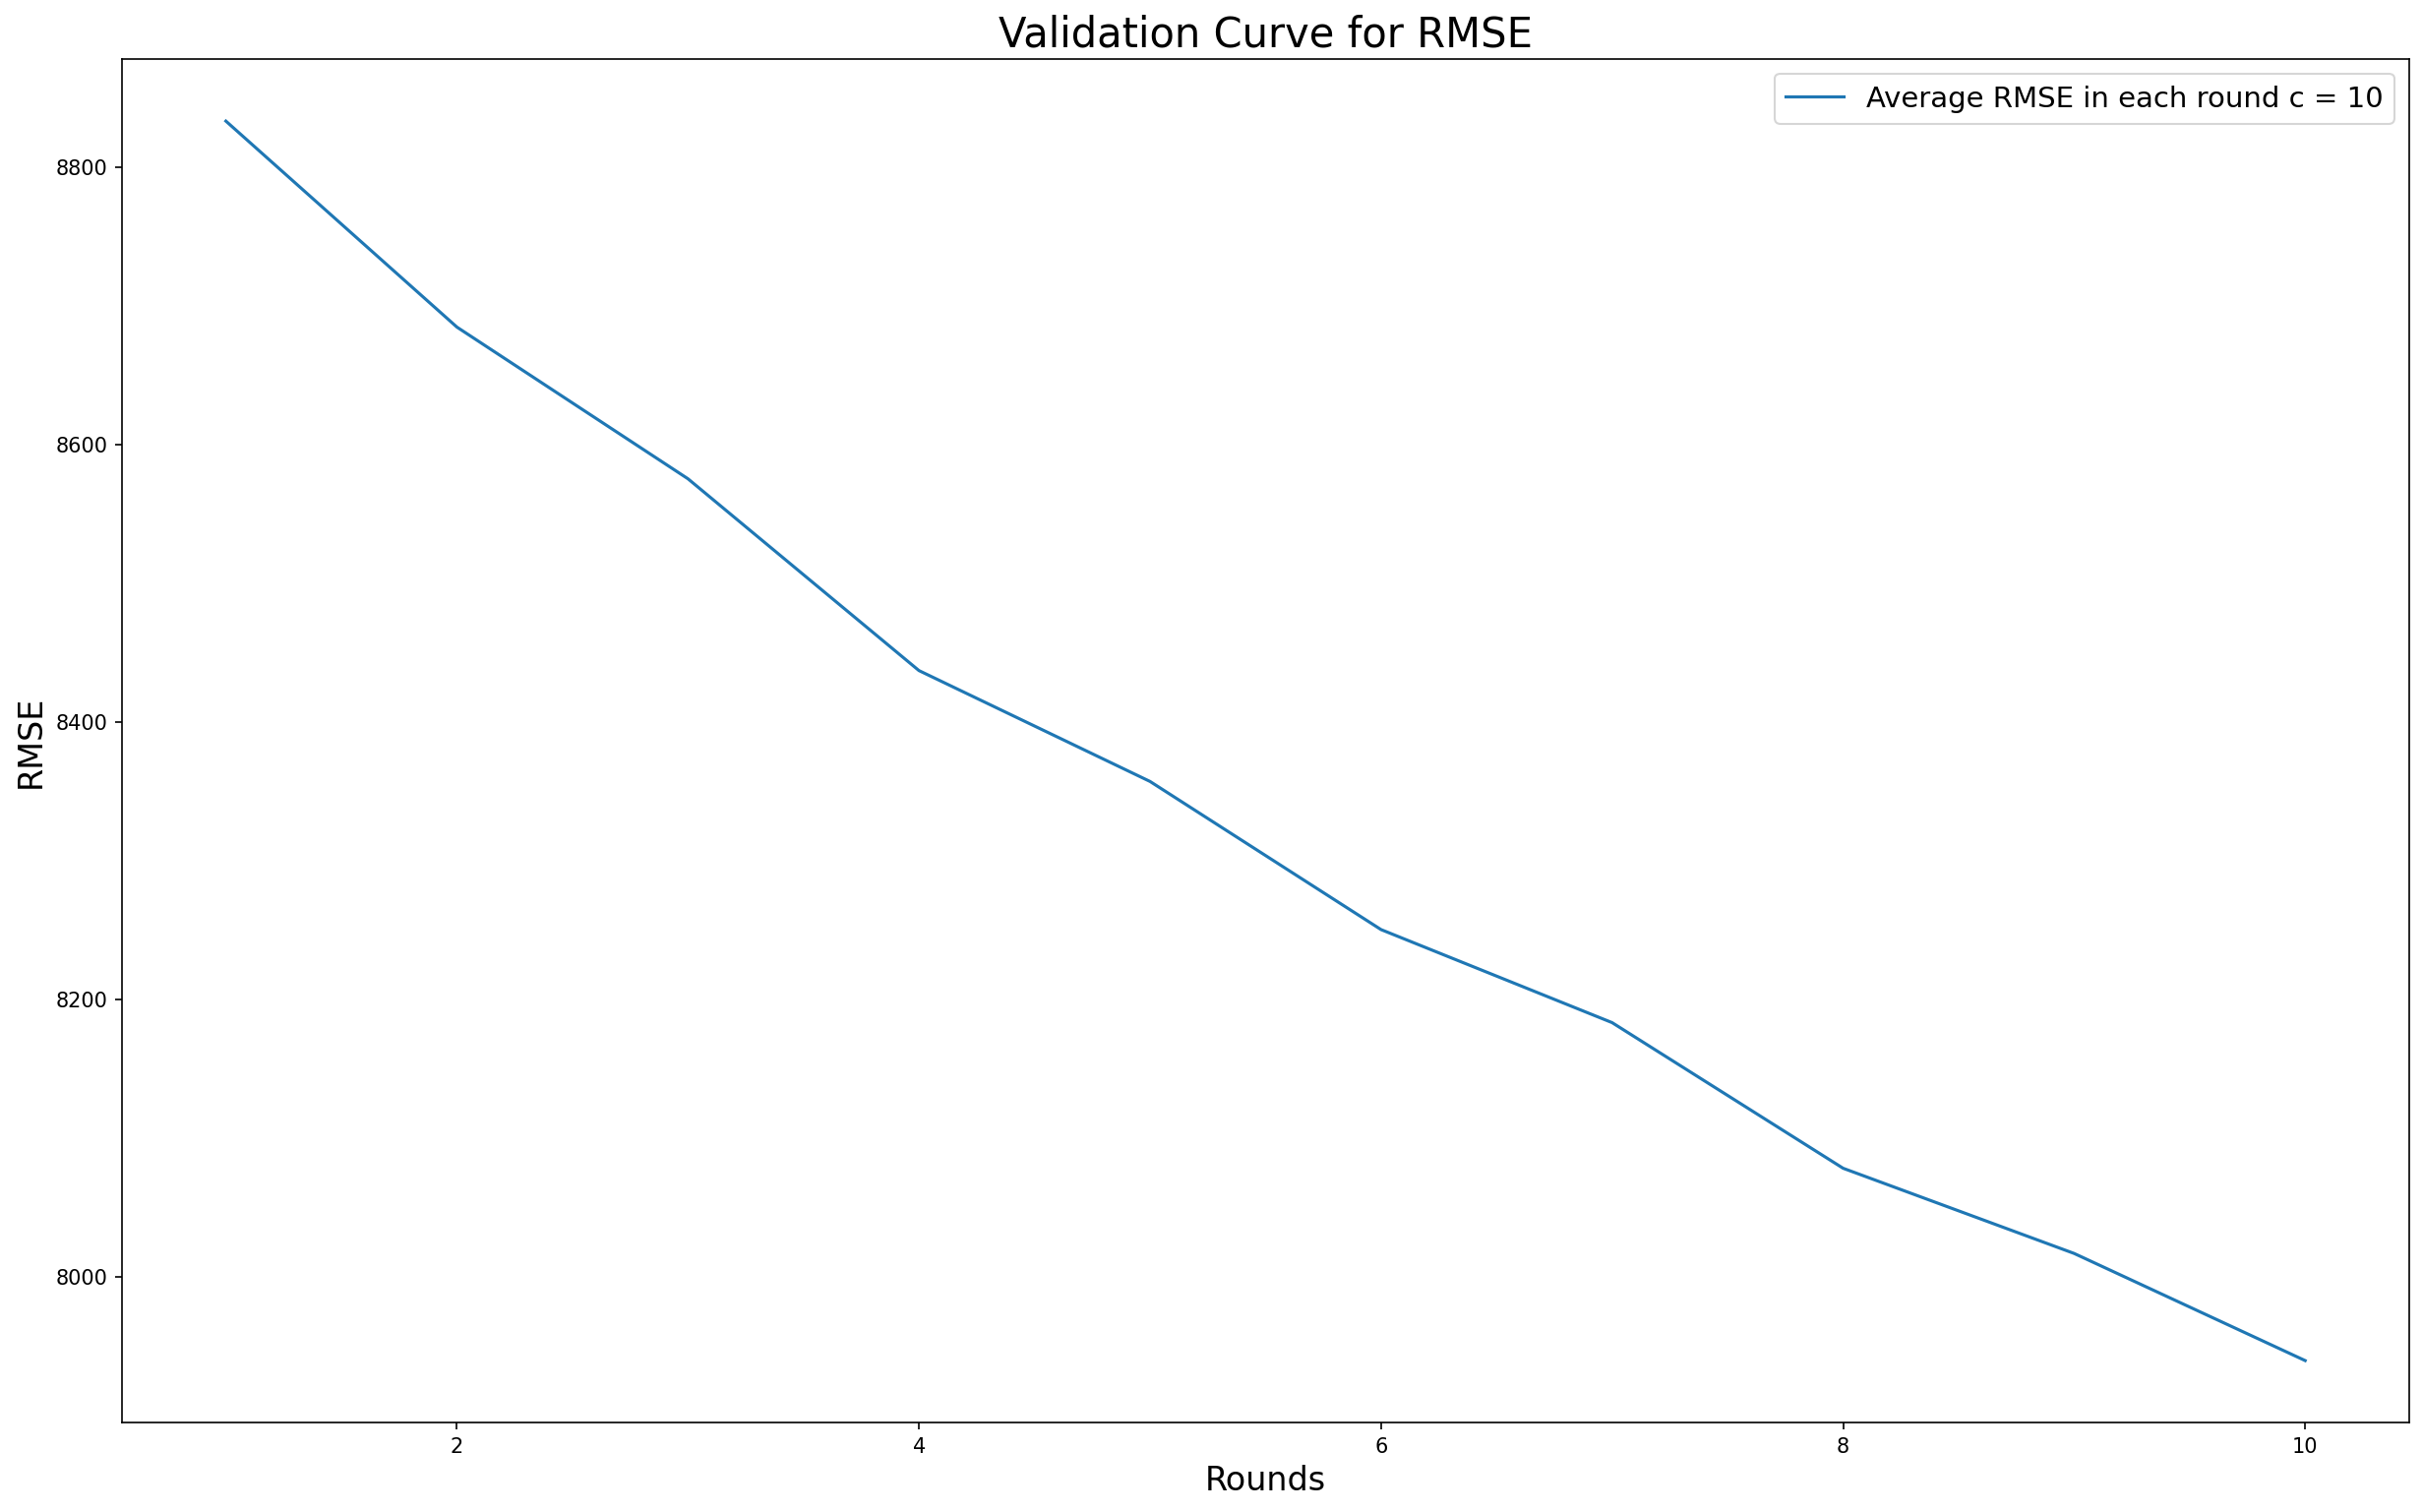

In [ ]:
# history of each client for training
flower_history.metrics_distributed_fit

# history of each client for validation
flower_history.metrics_distributed

x, y = [], []
for average_metrics in flower_history.metrics_distributed['average_metrics']:
    x.append(average_metrics[0])
    y.append(average_metrics[1]['valid_rmse'])


plt.figure(figsize=(20, 12), dpi = 150)

plt.plot(x, y, label='Average RMSE in each round c = '+str(NUM_CLIENTS))
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.legend()
plt.title('Validation Curve for RMSE', fontsize=20)
#plt.show()
plt.legend(fontsize=14)
plt.savefig(f'average_val_RMSE_rounds_{NUM_ROUNDS}_c_{NUM_CLIENTS}.png', bbox_inches='tight')

x =  []
y = [[] for i in flower_history.metrics_distributed['client_metrics'][0][1]['valid_rmse']]
for client_metrics in flower_history.metrics_distributed['client_metrics']:
    x.append(client_metrics[0])
    for idx, client_loss in enumerate(client_metrics[1]['valid_rmse']):
        y[idx].append(client_loss)


plt.figure(figsize=(20, 12), dpi = 150)
for client_num, loss_ in enumerate(y):
    plt.plot(x, loss_, label='Val RMSE of c: '+str(client_num))
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.legend()
plt.title('Validation Curve for RMSE (individual client), c = '+str(NUM_CLIENTS))
#plt.show()
plt.legend(fontsize=14)
plt.savefig(f'individual_val_average_RMSE_rounds_{NUM_ROUNDS}_c_{NUM_CLIENTS}.png', bbox_inches='tight')



plt.figure(figsize=(20, 12), dpi = 150)
for client_num, loss_ in enumerate(y):
    plt.plot(x, loss_)
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.legend()
plt.title('Validation Curve for RMSE (individual client), c = '+str(NUM_CLIENTS))
#plt.show()
plt.legend(fontsize=14)
plt.savefig(f'individual_val_average_RMSE_rounds_{NUM_ROUNDS}_c_{NUM_CLIENTS}_no_legend.png', bbox_inches='tight')

x, y = [], []
for average_metrics in flower_history.metrics_distributed_fit['average_metrics']:
    x.append(average_metrics[0])
    y.append(average_metrics[1]['average loss'])

plt.figure(figsize=(20, 12), dpi = 150)

plt.plot(x, y, label='Average loss in each round c = '+str(NUM_CLIENTS))
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.title('Training Curve for Loss', fontsize=20)
plt.legend(fontsize=14)
#plt.show()
plt.savefig(f'average_training_loss_rounds_{NUM_ROUNDS}_c_{NUM_CLIENTS}.png', bbox_inches='tight')

x =  []
y = [[] for i in flower_history.metrics_distributed_fit['client_metrics'][0][1]['loss']]
for client_metrics in flower_history.metrics_distributed_fit['client_metrics']:
    x.append(client_metrics[0])
    for idx, client_loss in enumerate(client_metrics[1]['loss']):
        y[idx].append(client_loss)

plt.figure(figsize=(20, 12))
for client_num, loss_ in enumerate(y):
    plt.plot(x, loss_, label='Training Loss of client: '+str(client_num))
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.title('Training Curve for Loss (individual client) c = '+str(NUM_CLIENTS))
#plt.show()
plt.savefig(f'individual_average_training_loss_rounds_{NUM_ROUNDS}_c_{NUM_CLIENTS}.png', bbox_inches='tight')

plt.figure(figsize=(20, 12))
for client_num, loss_ in enumerate(y):
    plt.plot(x, loss_)
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.title('Training Curve for Loss (individual client) c = '+str(NUM_CLIENTS))
#plt.show()
plt.savefig(f'individual_average_training_loss_rounds_{NUM_ROUNDS}_c_{NUM_CLIENTS}_no_label.png', bbox_inches='tight')


In [ ]:
with open('flower_history.pkl', 'wb') as f:
    pickle.dump(flower_history, f)

with open('flower_history.pkl', 'rb') as f:
    history = pickle.load(f)


x, y = [], []
print(history.metrics_distributed['loss'])
for average_metrics in history.metrics_distributed['loss']:
    x.append(average_metrics[0])
    y.append(average_metrics[1])


plt.figure(figsize=(12, 6))

plt.plot(x, y, label='Average loss')
plt.xlabel('Rounds')
plt.ylabel('loss')
plt.legend()
plt.show()

KeyError: ignored